In [1]:
%matplotlib inline 

import numpy as np
import os
from matplotlib import pyplot as plt

#loading the images
import skimage.io as io



In [27]:
import random
from skimage.transform import resize

fns = os.listdir('MNIST/3')

imgs = []

for i in [3, 8]:
    for fn in os.listdir('MNIST/' + str(i)):
        img = io.imread('MNIST/%d/%s' % (i, fn), dtype=np.float64)
        img = resize(img, (29, 29))
        img = img / 255
        imgs.append((img, i))

random.shuffle(imgs)

inputs = np.zeros((len(imgs), 29, 29))
outputs = np.zeros((len(imgs)))

for i, (img, value) in enumerate(imgs):
    inputs[i] = img
    outputs[i] = 1 if value == 8 else 0
    
inputs = inputs.reshape(len(inputs), 29, 29, 1)


/home/rafael/mestrado/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
print(inputs.shape)

(8414, 29, 29, 1)


In [ ]:
import math
import scipy.ndimage.filters

def convolve(mat, filter): 
    res = scipy.ndimage.filters.convolve(mat, filter)
    (dline, dcol) = (filter.shape[0] - 1) // 2, (filter.shape[1] - 1) // 2
    return res[dline : -dline, dcol : -dcol]
        
def sigmoid(x):
    try:
        return 1 / (1 + math.exp(-x))
    except OverflowError:
        return 1.0 if x > 0 else 0.0

In [ ]:
def grad_filter2(factor, mat_inter):
    a = mat_inter.copy()
    return a * factor

def grad_filter1(mat, ginter): 
    a = np.zeros(ginter.shape)
    
    dline, dcol = (a.shape[0] - 1) / 2, (a.shape[1] - 1) / 2
    
    for w_i in np.ndindex(a.shape): 
        for i in np.ndindex(a.shape):
            original_i = (i[0] + w_i[0], i[1] + w_i[1])
            a[w_i] += ginter[i] * mat[original_i]
            
    return a
        
def grad_mat_inter(factor, filter2):
    a = filter2.copy()
    return a * factor

def normalize(mat):
    return mat / 255.0

def train_step(mat, filter1, filter2, correct):
    mat_inter = convolve(mat, filter1)
    result_before_sig = convolve(mat_inter, filter2)[0,0]
    result = sigmoid(result_before_sig)
    
    print('result_before_sig: ', result_before_sig, 'result:', result, 'correct:', correct)
    
    factor = (result - correct) * result * (1 - result)
    
    print('factor: ', factor )
    
    gf2 = grad_filter2(factor, mat_inter)
    ginter = grad_mat_inter(factor, mat_inter)
    gf1 = grad_filter1(mat, ginter)
    
    lr = 0.001
    
    for i in np.ndindex(filter1.shape): 
        #print(lr * gf1[i])
        filter1[i] -= lr * gf1[i]
        filter2[i] -= lr * gf2[i]
    
    pred = 1 if result > 0.5 else 0
    return pred == correct

In [ ]:
from IPython.display import clear_output

# mat = imgs[3][10]
factor = 0.0001
filter1 = np.random.rand(15,15) * factor
filter2 = np.random.rand(15,15) * factor

(img, number) = imgs[3]

for a in range(100):
    res = train_step(img, filter1, filter2, 1 if number == 8 else 0)

#we are identifying if we obtain an 8
# for a in range(100):
#     right = 0
    
#     for (i, (img, number)) in enumerate(imgs):
#         res = train_step(img, filter1, filter2, 1 if number == 8 else 0)
#         if res: right += 1
#         clear_output(wait=True)
#         print(i, '=', right / (i+1) * 100)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 15, 15, 1)         226       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 1)           226       
_________________________________________________________________
flatten_33 (Flatten)         (None, 1)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 2         
Total params: 454
Trainable params: 454
Non-trainable params: 0
_________________________________________________________________
None


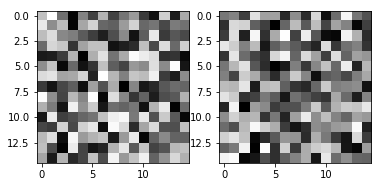

[array([[1.6225315]], dtype=float32), array([0.], dtype=float32)]
Train on 8414 samples, validate on 842 samples
Epoch 1/10
8414/8414 [==============================] - 3s 382us/step - loss: 0.5610 - acc: 0.7278 - val_loss: 0.3785 - val_acc: 0.9145
Epoch 2/10
8414/8414 [==============================] - 3s 302us/step - loss: 0.3431 - acc: 0.9395 - val_loss: 0.2889 - val_acc: 0.9442
Epoch 3/10
8414/8414 [==============================] - 2s 295us/step - loss: 0.2726 - acc: 0.9472 - val_loss: 0.2479 - val_acc: 0.9466
Epoch 4/10
8414/8414 [==============================] - 3s 323us/step - loss: 0.2314 - acc: 0.9528 - val_loss: 0.2119 - val_acc: 0.9561
Epoch 5/10
8414/8414 [==============================] - 3s 300us/step - loss: 0.2036 - acc: 0.9565 - val_loss: 0.1900 - val_acc: 0.9561
Epoch 6/10
8414/8414 [==============================] - 3s 299us/step - loss: 0.1831 - acc: 0.9577 - val_loss: 0.1737 - val_acc: 0.9572
Epoch 7/10
8414/8414 [==============================] - 3s 320us/step -

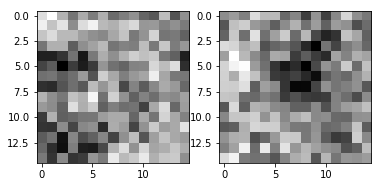

[array([[1.830285]], dtype=float32), array([-2.2302725], dtype=float32)]


In [220]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

model = Sequential()

firstFilter = Conv2D(1, kernel_size=(15, 15), activation='relu', input_shape=(29, 29, 1))

model.add(firstFilter)

secondFilter = Conv2D(1, (15, 15), activation='relu')
model.add(secondFilter)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

train_size = int(len(inputs) * 0.9)
train_in = inputs[:train_size]
train_out = outputs[:train_size]
test_in = inputs[train_size:]
test_out = outputs[train_size:]

draw_filters(model)

model.fit(inputs, outputs,
          epochs=10,
          verbose=1, 
          validation_data=(test_in, test_out))

draw_filters(model)

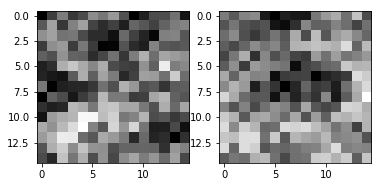

[array([[-1.931569]], dtype=float32), array([2.0552342], dtype=float32)]


In [135]:
def draw_filters(model):    
    plt.subplot(121)
    weights = model.layers[0].get_weights()[0]
    weights = weights.reshape(15,15)
    plt.imshow(weights, cmap="gray")
    
    plt.subplot(122)
    weights = model.layers[1].get_weights()[0]
    weights = weights.reshape(15,15)
    plt.imshow(weights, cmap="gray")
    
    plt.show()
    
    weights = model.layers[3].get_weights()
    print(weights)
    
draw_filters(model)


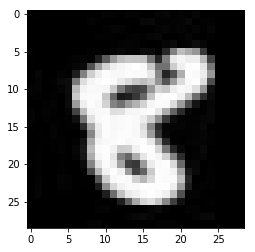

1/1 [==============================] - 0s 1ms/step
Predict: 0.88647544
(29, 29)
Before last layer: 1.8052598353147828
Before sigma: -1.4317497053237687
After sigma: 0.1928262062646259


In [201]:
import scipy.ndimage.filters

from scipy.special import expit

def relu(mat):
    mat[mat < 0] = 0

id = 16

img = inputs[id].reshape(29,29)
plt.imshow(img, cmap="gray")
plt.show()

res = model.predict(inputs[id:id+1], verbose=1)[0][0]
print("Predict:", res)

img = inputs[id:id+1].reshape(29,29)
print(img.shape)

filter1 = model.layers[0].get_weights()[0].reshape(15,15)
filter2 = model.layers[1].get_weights()[0].reshape(15,15)

res = scipy.ndimage.filters.convolve(img, filter1)[7:22, 7:22]
relu(res)
res = scipy.ndimage.filters.convolve(res, filter2)[7:8, 7:8]
relu(res)
res = res[0,0]
print("Before last layer:", res)

weights = model.layers[3].get_weights()
coeff = weights[0][0,0]
bias = weights[1][0]

res = coeff * res + bias
print("Before sigma:", res)
res = expit(res)
print("After sigma:", res)

0.097064756


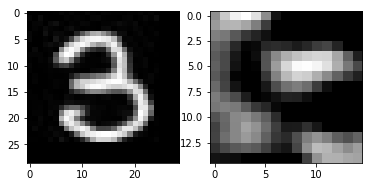

In [269]:
from keras.models import Model

id=25
imgKeras = inputs[id:id+1]
#imgKeras = np.ones((1,29,29,1))
#print(imgKeras.shape)
imgConv = imgKeras.reshape(29,29)

res = model.predict(imgKeras)
print(res[0][0])

plt.subplot(121)
plt.imshow(imgConv, cmap="gray")

intermediate_layer_model = Model(inputs=firstFilter.input, outputs=firstFilter.output)
intermediate_output = intermediate_layer_model.predict(imgKeras).reshape(15,15)

plt.subplot(122)
plt.imshow(intermediate_output, cmap="gray")
plt.show()

#print(model.layers[0].get_weights())
# filter1 = model.layers[0].get_weights()[0].reshape(15,15)
# res = scipy.ndimage.filters.convolve(imgConv, filter1)[7:22, 7:22]
# relu(res)
# print(res[0])